## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [2]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [589]:
# if not os.path.exists('sonnets.txt'):
#     !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [590]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
out = ''.join(text).lower()

assert len(out) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(out) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [5]:
# # !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r', encoding='utf8') as iofile:
#     text = iofile.readlines()
    
# text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# # Join all the strings into one and lowercase it
# # Put result into variable text.

# # Your great code here
# out = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [594]:
tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [595]:
token_to_id = {}
id_to_token = {}
for _, token in enumerate(tokens):
    token_to_id[token] = _
    id_to_token[_] = token
    

# dict <char>:<index>
# Your great code here
out_ = '\n'.join([x for x in out.split("\n\n") if len(x) > 20])
maxlen=60
text2=[]
for i in range(len(out_)-maxlen-1):
    text2.append(out_[i:i+maxlen])
num_tokens = len(tokens)
MAX_LENGTH = max(map(len, text2))

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [159]:
from IPython.display import clear_output
from random import sample
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

In [596]:
# Your code here
def to_matrix(texts, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    max_len = max_len or max(map(len, texts))
    texts_ix = np.zeros([len(texts), max_len], dtype) + pad

    for i in range(len(texts)):
        line_ix = [token_to_id[c] for c in texts[i]]
        texts_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        texts_ix = np.transpose(texts_ix)

    return texts_ix

class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=32, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden_prev):
        out, hidden = self.rnn(self.emb(x), hidden_prev)
        next_logits = self.hid_to_logits(out)
#         next_logp = F.log_softmax(next_logits, dim=-1)
        return hidden, next_logits
    
    def init_state(self, sequence_length):
        return torch.zeros(1, sequence_length, 128)
    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss()
history = []

Plot the loss function (axis X: number of epochs, axis Y: loss function).

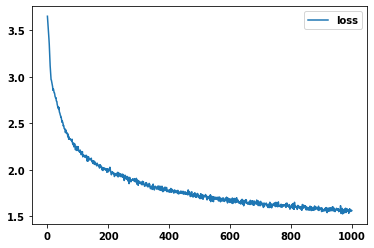

In [314]:
for i in range(1000):
    batch_ix = to_matrix(sample(text2, 128))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    hidden = model.init_state(128)
    _, next_logits = model(batch_ix, hidden)
    logp_seq = F.log_softmax(next_logits, dim=-1)
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
    
    # YOUR CODE HERE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    # YOUR CODE HERE
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [315]:
def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.init_state(1)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, :, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [324]:
print(generate_sample(model, seed_phrase = " ", max_length=500, temperature=0.5))

 thine eyes of the thee.
  thr blest thy not be the right have i world there beauty i counterank but self doth despot see:
    so so then desires the veart the reserve thee with my thy sommons to thy some thou love thee with the right the glate,
  and then my worth to be thy some shall etery that find,
  when the will grace should beauty abesone, my self beauty chist be be me come and strance thy life the the with the were of the poring astand that this such i cast to keed;
    then beauty,
  wh


In [325]:
print(generate_sample(model, seed_phrase = " ", max_length=500, temperature=0.8))

 thus pis deboud thy elless,
  nor brease my defilligusen and houf straise so thy beauty the sweet therefore chind of the is the brease?
  that ther in is all those look,
  and thus betite wond,
  that my poon the ficl's sun and vise,
  make gove, must the worth come.
    but my our hast love in thou look's says along on they?
  that your restros'd somp demempest my worst thee my labuted fied,
  with i heavine of state,
  and like in thate,
  be i grow''s his dweep
  to the mans thee retine wher


In [327]:
print(generate_sample(model, seed_phrase = " ", max_length=500, temperature=1))

 outly, and thou faltast, omk,
  i profstant, hold begn,
  but that beiny still ey! thou wiencume if ulles show see in,
  and more.
  nor all be every slays, that doth dicture my end steach right heathad frost he spial;
  all hagr be, now ast that they nig thee then thoses from hourt;
  that your art,
  and or time;
  from my frovious,
  weil
    thou in they dlador wath the substor takes dispice my frieh.
  for ambyt more giqed lows, are she love'st i when vielf best my formbrey,
  by as my me:


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [597]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        out, state = self.rnn(self.emb(x), prev_state)
        next_logits = self.hid_to_logits(out)
        return state, next_logits
    
    def init_state(self, sequence_length):
        return (torch.zeros(1, sequence_length, 128),torch.zeros(1, sequence_length, 128))
    
model2 = CharLSTMLoop()
opt = torch.optim.Adam(model2.parameters())
criterion = nn.NLLLoss()
history = []

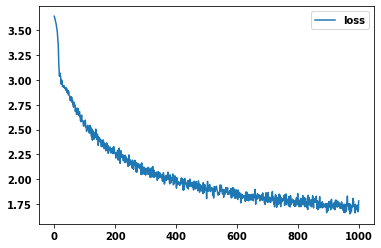

In [598]:
for i in range(1000):
    batch_ix = to_matrix(sample(text2, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    hidden = model2.init_state(32)
    _, next_logits = model2(batch_ix, hidden)
    logp_seq = F.log_softmax(next_logits, dim=-1)
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
    
    # YOUR CODE HERE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    # YOUR CODE HERE
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [599]:
def generate_sample2(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.init_state(1)
    
    for i in range(len(seed_phrase) - 1):
        _, hid_state = char_rnn(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, :, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [600]:
# Text generation with different temperature values here
print(generate_sample2(model2, seed_phrase = " ", max_length=500, temperature=0.1))

 the stare the stare the streets
  the stare the stare the stare the start the street the strees dear dears the streets,
  and the stare the stare the see the stare the self the self the stare the street,
  and the stare the stare the start the stare the self the singe the self the stord,
  the store the stare the stare the stare the stare the self the self the start,
    the stare the stare the stare the sore the stare the stare the street store the self the stare the street do me thee,
  the s


In [601]:
print(generate_sample2(model2, seed_phrase = " ", max_length=500, temperature=0.2))

 the some the store the stare the self the dear dear dears the say dears beauty the self thee store the sell and thee thee thee thee of thee thee thee thee,
  and the stare the store the thee the stare the since love,
  and the with the stare the strend,
  the mate the stare the say the self the say dear beart,
  and the sine in the shall be the store the self thee the dears i so dear doth the prove thee,
    thou that the stare thou thou art the san the self the beauty my seen thee,
    thou be


In [602]:
print(generate_sample2(model2, seed_phrase = " ", max_length=500, temperature=0.5))

  and do prows,
  for where the say in the dears when thee be the bet,
    thy mine and stince treing the giest that in thou art a thee beauty and thee,
  and sue this this my the shate in the sender thought.
  where to that these i kart the fater'd thou being,
    that these thee i gair to the beauty live heart beauty thou bet love broud,
  and that thou have then i that in thy seed the love my love,
    then plese that thought mise as thou the prown love thee of thy frave
  thou that loving th


In [603]:
print(generate_sample2(model2, seed_phrase = " ", max_length=500, temperature=1))

 do be thou richtwer of thoughss, bicind here my spartoon mist,
  but yeart, bid:
  but of sengomit
  but the brose, yout fooq
  shat thee baituen doth night,
  a doonde chave i wroch fhight fork, sige is demeberd.
  blowat, anmery mals make aloce do done,
    tounmymor sorti'd shal wintditt gommser veast,
  craie, so ay of my elkis' a dar-nown
  the cotlingt shals fhat weartmery which being angingurs in spersse,
  o! bist in thee stilst have somen as dom'lss ereth
  a chiwn do sorust lode beaut


In [604]:
print(generate_sample2(model2, seed_phrase = " ", max_length=500, temperature=2))

 brbaivinst deed: olks; blwavgdiltiwng hiin; ulf ilag'
t brfysyisloflmedmio! wothad'(t sicsrind hels bowy eoue,
, twoedsy cay'dfs movab
 i) veetdnes ynis?u?e-- of sklttim eed as!wilf:-.-uwnas aeghys, belirs:.
 'ecomun'st:s;s snewncl'st, crickseve?orry; fe, buind, myse byenjay, afv
, gwenc' stfimviq
  lfo!-
i hive; bwangipt qnexr my yoyngry ulpetua.
  do-gor aete itel vmlearewbess  adkers'di;
  whicht bnofel tios -ipfom; wighat buuz

  oagcwerfy, me, wist heach ckalseqdel-mbunusc oef wortoh;o;y?e


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [4]:
# Saving and loading code here
torch.save(model2, 'model2.pth')
model2 = torch.load('model2.pth')

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)

***Для интереса добавил аналогичный блок на корпусе текстов Eminem***

In [341]:
# Using another corpus (Eminem)
import pandas as pd

data = pd.read_csv("songdata.csv")

In [342]:
out = ''.join(list(data[data['artist'] == 'Eminem']['text'])).lower()
tokens = sorted(set(out))
token_to_id = {}
id_to_token = {}
for _, token in enumerate(tokens):
    token_to_id[token] = _
    id_to_token[_] = token

In [343]:
maxlen=40
text3=[]
for i in range(len(out)-maxlen-1):
    text3.append(out[i:i+maxlen])
num_tokens = len(tokens)
MAX_LENGTH = max(map(len, text3))

In [345]:
def to_matrix(texts, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    max_len = max_len or max(map(len, texts))
    texts_ix = np.zeros([len(texts), max_len], dtype) + pad

    for i in range(len(texts)):
        line_ix = [token_to_id[c] for c in texts[i]]
        texts_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        texts_ix = np.transpose(texts_ix)

    return texts_ix

class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=64, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
#         out, hidden = self.rnn(self.emb(x), hidden_prev)
        out, state = self.rnn(self.emb(x), prev_state)
        next_logits = self.hid_to_logits(out)
        return state, next_logits
    
    def init_state(self, sequence_length):
        return (torch.zeros(1, sequence_length, 128),torch.zeros(1, sequence_length, 128))
    
model3 = CharLSTMLoop()
opt = torch.optim.Adam(model3.parameters(), lr=0.01)
criterion = nn.NLLLoss()
history = []

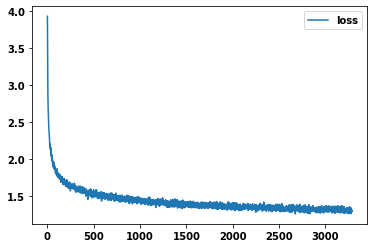

In [347]:
for i in range(3000):
    batch_ix = to_matrix(sample(text3, 128))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    hidden = model3.init_state(128)
    _, next_logits = model3(batch_ix, hidden)
    logp_seq = F.log_softmax(next_logits, dim=-1)
    # compute loss
    loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                 batch_ix[:, 1:].contiguous().view(-1))
    
    # YOUR CODE HERE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    # YOUR CODE HERE
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [348]:
def generate_sample2(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.init_state(1)
    
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, out = char_rnn(x_sequence[:, :, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])


print(generate_sample2(model3, seed_phrase = " ", max_length=200, temperature=0.6))

 around and as to say  
but it ain't no motherfucker, with a second from a little street  
a must of you  
i got a nine  
i ain't gonna go the way it ain't no now  
but i guess it's no fly we say what


In [350]:
print(generate_sample2(model3, seed_phrase = "i", max_length=300, temperature=0.4))

it's alright in the stop  
i just pull a shit  
and i stay and the back and be fucked to steps  
the shit  
the world is the shit  
i was done to his some  
i get the scratches  
it's just a fucking and about me  
what the sour  
there's no a better lost  
it's not a man a could coming a shit is the


In [539]:
print(generate_sample2(model3, seed_phrase = " ", max_length=300, temperature=0.45))

  
i speak up  
i'm set  
it's no more  
i never show me in the man in my mother as i was no more  
  
you make up to keep it  
she don't know i don't know what i was love with a pen  
if i had a man, here i ain't no more  
you don't know what i wanna say you get me  
i don't wanna get it  
you hear


In [585]:
print(generate_sample2(model3, seed_phrase = " ", max_length=300, temperature=0.45))

 it all and try to stay  
i make you the fuckin your corner  
then i slim shady) some the shit  
i smell i think me and the fuck i ain't no more shoot  
they callin'  
the way you ain't no ow mouth  
i got a charge to all i was done  
i'm a pen  
you need trick  
the make a ball a shit you can be th


In [804]:
print(generate_sample2(model3, seed_phrase = "she", max_length=400, temperature=0.5))

she gonna knows the way you lie  
i'm a park and hear the money and i suckin' a girl  
man i love you  
she seen the light back with the same slim body, i don't want to be you  
if you shit a little back with the way you're a ban the dad  
but i'm comin' off  
and he won't believe you wanna staying to stand why the whole boys and then  
i'm take my so been shit  
they say they're fucking in the wa
